# Deep Track Tutorial

This is a short jupyter notebook tutorial on how to use deeptrack for your experimental data. Different from other particle tracking software, deeptrack uses neural networks to track particles. It does this by learning from synthetic/training data which is defined by the user (that looks as close as possible to the experimental data), where the network learns what the particle looks like and returns its position. 

This notebook will be split in two parts; single particle tracking and multi-particle tracking. This is done namely for some differences between the methods. First, we look at how to setup the training data, this is pretty much the same for both single/multi particle tracking, with the exception for multi-particle tracking where you define more than 1 scatter. 

## Creating training data

The training/ sytnetic data is the data in which the neural network learns from. Essentially, the neural network will attempt to learn what your particle looks like (by looking at the colour of each individual pixel in relation to its surroundings), whereby attaching a "position" label to it, the network can make a relation between shape and a position (centre) of the particle, thus tracking your particle. Both the pixel array and the position are fed into the neural network to learn from. 

In [1]:
#Import modules

import numpy as np
import matplotlib.pyplot as plt
import deeptrack as dt
import random

In [2]:
#Choose image size 
IMAGE_SIZE = 128

First define a scatterer (cell below), this is the particle you wish to image (i.e a spherical colloid). Here, you define the properties of the particle, its position, intensity, radius. It is important here to add some randomness to the position of the particle. This is so when you create a new instance of a particle, it has a new position. This is done so when you have experimental data and for example, it is not in the centre of the image, the neural network can recognise this. 

In [ ]:
#Particle goes here

IMAGE_SIZE = 64

from deeptrack.scatterers import Sphere
from deeptrack.scatterers import PointParticle
from deeptrack.cubescatterers import Cube

scatterer = Sphere(
    intensity=1.15,          # Squared magnitude of the field
    position_unit="pixel",  # Units of position (default meter)
    #position= lambda: np.random.normal(loc = (IMAGE_SIZE/2), scale = 1, size = 2),      # Position of the particle
    position = lambda: np.random.randint(((IMAGE_SIZE/2) - 20),((IMAGE_SIZE/2) +20), size=2), 
    radius=2e-6,            # Radius of the sphere
    upsample=2              # Amount the resolution is upsampled for accuracy
)

#NOTE! You can also define your own scatters such as a 'cube', this can be done by adjusting some of the pre-defined
#scatters in the source code. 

#scatterer = Cube(
#    intensity=100,          # Squared magnitude of the field
#    position_unit="pixel",  # Units of position (default meter)
#    #position= lambda: np.random.normal(loc = (IMAGE_SIZE/2), scale = 1, size = 2),      # Position of the particle
#    position = lambda: np.random.randint(((IMAGE_SIZE/2) - 20),((IMAGE_SIZE/2) +20), size=2), 
#    #position = lambda: np.random.rand(2) * IMAGE_SIZE, 
#    radius=0.5e-6,            # Radius of the sphere
#    upsample=2              # Amount the resolution is upsampled for accuracy
#)

Next, define the optics. Here you can chose between brightfield and fluorescence microscope. The properties of the microscope are also defined here, its NA, wavelength, resolution etc. If needed, multiple wavelengths can be averaged over (as is in a brightfield microscope), however this can make running the sample pretty slow. 

In [5]:
#Optics
from deeptrack.optics import Brightfield
from deeptrack.aberrations import SphericalAberration

optics = Brightfield(
    NA=0.7,                             # Numerical aperture
    wavelength=660e-9,                  # Wavelength of illuminating light
    resolution=1e-6,                    # Pixel size of the camera. Also determines z-resolution
    magnification=5,                   # Magnification of the optical aperature
    refractive_index_medium=1.33,       # Refractive index of the medium
    upscale=2,                          # Upscales the pupil function for accuracy
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),       # Extracts a part of the output image (x, y, width, height)
    padding=(10, 10, 10, 10),           # Pads the imge with this number of pixels to avoid edge effects (left, right, up, down)
    aberration=None                     # Adds some aberration to the optical system. See aberrations_example for details
)

Now, the particle can be "imaged", where noise can also be added to more accurately represent experimental data. NB, a very similar instance of the cell below is repeated when defining the training data. 

In [ ]:
from deeptrack.noises import Offset
offset = dt.Add(value=1)

poisson_noise = dt.Poisson(snr=40, background=offset.value)
gaussian_noise = dt.Gaussian(mu=0, sigma=0.15)

imaged_particle = optics(scatterer) + gaussian_noise

In [17]:
#print the image
imaged_particle.update()
output_image = imaged_particle.resolve()
plt.axis('off')
plt.imshow(np.squeeze(output_image), cmap='gray')

#Chose to also save the image 
plt.savefig('C:\\Users\\yahel\\Documents\\Leiden Physics\\MSc Project 2\\Tracking\\test data\\syntheticdatasphere.png', bbox_inches='tight', transparent=True, pad_inches=0)

Now an image of the particle has been created, a small but important step to take is to compare the average pixel colour of the synthetic data and the experimental data. If the histograms do not match, the network is less likely to correctly predict the postion of the particle. This makes sense because the network is learning to define a position from certain pixel values (and their position in the array), so if the particle has different pixel values (say it is darker) the prediction is likely to be wrong. 

In [ ]:
#Load an example of experimental data (can also use for the predicting stage)
import cv2 as cv
img = cv.imread('C:\\Users\\yahel\\Documents\\Leiden Physics\\MSc Project 2\\Tracking\\test data\\nd084.png')
img_h = np.shape(img)[0]
img_w = np.shape(img)[1]

#normalize, convert to GS, resize. 
frame = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)
frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) / 255
frame_resize = cv.resize(frame, (IMAGE_SIZE, IMAGE_SIZE))

#for histogram
hist_frame = cv.cvtColor(img, cv.COLOR_BGR2GRAY) / 255
hist_resize = cv.resize(hist_frame, (IMAGE_SIZE, IMAGE_SIZE))

In [ ]:
#Print histograms to check for pixel colour
#Experimental Data
plt.hist(frame_resize.ravel(),256,[0,1])
plt.title("Experimental data histogram")
plt.show()
plt.figure()

#Synthetic data
sim_im = cv.imread('C:\\Users\\yahel\\Documents\\Leiden Physics\\MSc Project 2\\Tracking\\test data\\syntheticdatasphere.png')
sim_gr = cv.cvtColor(sim_im, cv.COLOR_BGR2GRAY)
plt.hist(sim_gr.ravel(),256,[0,256])
plt.title("synthetic data histogram")
plt.show()

### 1. Single Particle Tracking

Now, the model and architecure of the neural network can be set. Here is where the two of the main differences between single and multiparticle tracking are. For single particle tracking, a Convolutional Neural Network (CNN) is used, with the position property as the label, multipartcle tracking will be explained below. 

The input_shape should match the shape of your data, here "(IMAGE_SIZE, IMAGE_SIZE, 1)", means we have an array that has the length and width of the size of the image, with the "1" denoting it has one dimension (it is a GS image). The architecure (conv/dense layers) can be adjusted, however it is important to ensure that it does not have too many or too little layers. Too many layers leads to too many parameters to be adjusted, which can lead to overfitting, whilst too little can lead to underfitting. 

The number of outputs is set to two, this will be the coordinates of the position that the model predicts 

In [19]:
from deeptrack.math import NormalizeMinMax
from deeptrack.models import convolutional
from deeptrack.dropoutmodels import convolutionaldr

# DEFINE LABEL FUNCTION (this is also called get_label in some other examples)
def get_position(image):
    return image.get_property("position") / IMAGE_SIZE

#Define Model 
model = dt.models.convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), 
    conv_layers_dimensions=(8, 16, 32), 
    dense_layers_dimensions=(16,),
    droupout = 0.2,
    number_of_outputs=2,
    output_activation="linear",   
)

model.summary()

Next, the training set is defined. This is used as the input into the neural network. The trainig_set is used by a generator, which continually defines new data that can be fed into the network so it can be trained. 

In [ ]:
#DEFINE TRAINING SET
normalization = NormalizeMinMax(min=0, max=1)

#Noise
# Adds a constant value to the background
offset = dt.Add(value=0.1)

# Introduce Poisson noise to the image
poisson_noise = dt.Poisson(snr=30, background=offset.value)

#Track 1 particle
training_set =  optics(scatterer) + normalization + poisson_noise

The model is ready to be used and trained. First, the data is split into the training set and a validation set. The validation set is a seperate set of data that is used to test the validity of the neural network, i.e how well does the network perform at that stage on an unseen set of data. 

As mentioned above, the generator is used to continually generate a new image to be fed into the network, here you can set how many images to be made by using "min_size" and "max_size". Generally the more data to learn on the better, however, both generating images and learning on large data sets can take longer. 

model.fit() is line that actually trains the network, in this section, hyper-parameters (learning/dropout rate) and loss function can be set. Hyper-parameters can be adjusted, since they also have an impact on how well the network learns, however the standard setting should work well. The loss function also needs to be set correctly, since certain loss functions work better for different purposes (more on this can be found online). The number of epochs is how many times we repeat the learning process. 

At the end of the training, it is important to evaluate wether the network has been learning at all. Normally this can be done by looking at the loss/ validation_loss or the accuracy/ validation_accuracy. The more important one is the validation_loss/accuracy since this is the performance on the unseen data sets. Genreally, the loss should decrease overtime and the accuracy should increase. One can tell if there is over-fitting (I believe this can be seen by the training score being higher than the validation score, with the validation score remaining somewhat the same) or the network is not learning at all (nothing changes)

In [ ]:
#TRAIN TRACKER
TRAIN_MODEL = True 

#import modules from keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

#Training & Validation set sizes (90-10 split)
min_size = 3000
max_size = 4000
val_size = int(min_size*0.1)

#Make a validation set
validation_set_size = val_size
validation_set = [training_set.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_position(image) for image in validation_set]


#Train the model
if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        training_set, 
        get_position, 
        min_data_size = min_size,
        max_data_size = max_size,
        batch_size = 100, 
        )
    
    histories = []
    
    with generator:
        
        #Allows you to change some things also in the network & give metrics
        opt = keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
        
        #The thing that actually trains the data
        h = model.fit(
            generator, 
            validation_data = (
                np.array(validation_set), 
                np.array(validation_labels)
            ),
            callbacks = [EarlyStopping(patience = 30, restore_best_weights = True)], 
            epochs = 50, 
        )
        
    #plot your acc/loss
    plt.plot(h.history["accuracy"], 'm')
    plt.plot(h.history["val_accuracy"], 'c')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.figure()
    plt.plot(h.history["loss"], 'g')
    plt.plot(h.history["val_loss"], 'r')
    plt.legend(['loss', 'val_loss'])  
#If you want to see the history in full
#print(h.history)

First, the network performance can be visualised on some more synthetic data. Here, the real position and predicted position can be overlayed on each other. The distance between the two is calculated so an estimate of the error in the fit can be calculated. 

In [ ]:
images, real_positions = generator[0]
print(np.shape(images))
measured_positions = model.predict(images)

mxs = []
mys = []
rxs = []
rys = []

for i in range(2):
    
    image = np.squeeze(images[i])
    
    measured_position_x = measured_positions[i, 1] * IMAGE_SIZE
    measured_position_y = measured_positions[i, 0] * IMAGE_SIZE
    
    mxs.append(measured_position_x)
    mys.append(measured_position_y)
    
    real_position_x = real_positions[i, 1] * IMAGE_SIZE
    real_position_y = real_positions[i, 0] * IMAGE_SIZE
    
    rxs.append(real_position_x)
    rys.append(real_position_y)

    plt.imshow(image, cmap='gray')
    plt.scatter(real_position_x, real_position_y, s=70, c='r', marker='x')
    plt.scatter(measured_position_x, measured_position_y, s=100, marker='o', facecolor='none', edgecolors='b')
    plt.show()
    
mxs = np.array(mxs) 
mys = np.array(mys)
rxs = np.array(rxs)
rys = np.array(rys)

dx = np.subtract(mxs,rxs)
dy = np.subtract(mys,rys)

r = np.sqrt(np.square(dx) + np.square(dy))
print(r)

plt.figure()
plt.plot(r)
print("avg dist in pixels", np.average(r))
print("as a % of the image", (np.average(r)/IMAGE_SIZE)*100)

Finally, the model can be used to predict on experimental data. 

In [ ]:
measured_positions = model.predict(np.reshape(frame_resize, (1, IMAGE_SIZE, IMAGE_SIZE, 1)))

measured_position_x = measured_positions[0, 1] * IMAGE_SIZE #img_h
measured_position_y = measured_positions[0, 0] * IMAGE_SIZE #img_w

print(measured_position_x)
print(measured_position_y)

plt.imshow(frame_resize, cmap='gray')
plt.scatter(measured_position_x, measured_position_y, s=100, marker='o', facecolor='none', edgecolors='b')
plt.show()

### 2. Multi Particle Tracking

This section runs through multi-particle tracking. This is mostly the same except for the fact that the model used is a UNET rather than a CNN. 

First, redefine the data set such that more than one particles are included. 

In [ ]:
from deeptrack.scatterers import Sphere
from deeptrack.scattererscopy import Cube
s1 = Sphere(
    position=(50 + random.randint(-2,2), 50 + random.randint(-2,2)),
    intensity = 15, 
    position_unit="pixel",
    radius=0.5e-6,
    particle_type = 0
)

s2 = Sphere(
    position=(50 + random.randint(-2,2),65 + random.randint(-2,2)),
    intensity = 1.15,
    position_unit="pixel",
    radius=0.5e-6,
    particle_type = 1
)

In [ ]:
illumination_val = dt.Add(value = 7)

brightfield_microscope = dt.Brightfield(
    NA=0.9,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(32, 32, 32, 32),
    upscale=2, 
    illumination = illumination_val
)

# DEFINE TRAINING SET
normalization = dt.NormalizeMinMax(min=0, max=1)

# Adds a constant value to the background
offset = dt.Add(value=0.1)

# Introduce Poisson noise to the image
poisson_noise = dt.Poisson(snr=30, background=offset.value)

Here, the syntax for including multiple particles is slightly different. First a "sample" is created by adding particles together, then they are all imaged together in the microscope. 

In [ ]:
sample = (s1) + (s2)
image_of_particle = brightfield_microscope(sample) + normalization + poisson_noise

In [ ]:
#NB When running this myself I could not get the images to update... 

image_of_particle.update()
output_image = image_of_particle.resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.axis('off')
plt.savefig('C:\\Users\\Houston\\Documents\\Test Data\\Ring\synthetic2by2ring.png', bbox_inches='tight', transparent=True, pad_inches=0)

In [ ]:
# Histogram Comparison 

#Load an example of experimental data (can also use for the predicting stage)
import cv2 as cv
img = cv.imread('C:\\Users\\Houston\\Documents\\Test Data\\Ring\\2by2.png')
img_h = np.shape(img)[0]
img_w = np.shape(img)[1]

frame = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)
frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) / 255
frame_resize = cv.resize(frame, (IMAGE_SIZE, IMAGE_SIZE))

#for histogram
hist_frame = cv.cvtColor(img, cv.COLOR_BGR2GRAY) / 255
hist_resize = cv.resize(hist_frame, (IMAGE_SIZE, IMAGE_SIZE))

#Print histograms to check for pixel colour
#Experimental Data
plt.hist(frame_resize.ravel(),256,[0,1])
plt.title("Experimental data histogram")
plt.show()
plt.figure()

#Synthetic data
sim_im = cv.imread('C:\\Users\\Houston\\Documents\\Test Data\\Ring\synthetic2by2ring.png')
sim_gr = cv.cvtColor(sim_im, cv.COLOR_BGR2GRAY) 
sim_resize = cv.resize(sim_gr, (IMAGE_SIZE, IMAGE_SIZE) )
plt.hist(sim_resize.ravel(),256,[0,256])
plt.title("synthetic data histogram")
plt.show()

One other difference is the creation of the training label. Instead of using a position as a label, a mask is used. 

In [23]:
#Training Label

CIRCLE_RADIUS = 5

X, Y = np.mgrid[:2*CIRCLE_RADIUS, :2*CIRCLE_RADIUS]

circle = (X - CIRCLE_RADIUS + 0.5)**2 + (Y - CIRCLE_RADIUS + 0.5)**2 < CIRCLE_RADIUS**2
circle = np.expand_dims(circle, axis=-1)

get_masks = dt.SampleToMasks(
    lambda: lambda image: circle,
    output_region=lambda:brightfield_microscope.output_region,
    merge_method="or"
)

def get_label(image_of_particles):
    return get_masks.update().resolve(image_of_particles)

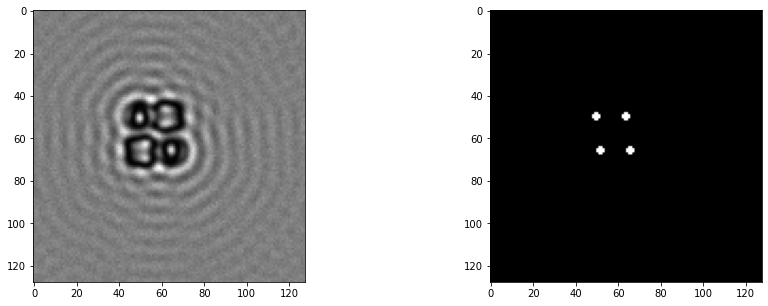

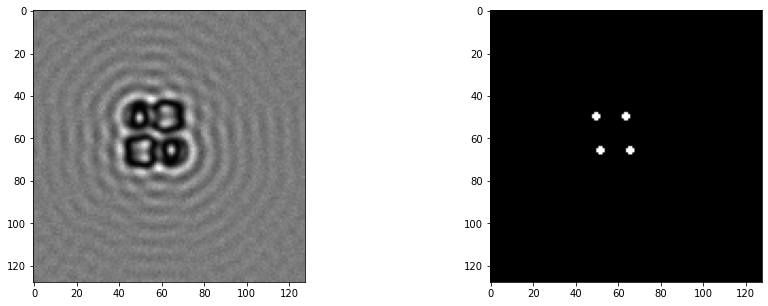

In [24]:
#Show data with the mask

NUMBER_OF_IMAGES = 2

for _ in range(NUMBER_OF_IMAGES):
    plt.figure(figsize=(15, 5))
    dataset.update()
    image_of_particle = dataset.resolve(skip_augmentations=True)
    particle_label = get_label(image_of_particle)
    plt.subplot(1, 2, 1)
    plt.imshow(image_of_particle[..., 0], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(particle_label[..., 0] * 1.0, cmap="gray")

Here, the UNET is defined. The advantage of the UNET is that is can return multiple outputs, rather than in the CNN where the number of outputs is set (Whilst the number can be changed, you cannot get it to return an array of positions for example). Note that the metrics and output activations are also different. 

In [25]:
# Define generator:

generator = dt.generators.ContinuousGenerator(
    dataset,
    get_label,
    batch_size=32,
    min_data_size=2**10,
    max_data_size=2**12
)

# Define Model 

import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers

loss = dt.losses.flatten(
    dt.losses.weighted_crossentropy((10, 1))
)
metric = dt.losses.flatten(
    dt.losses.weighted_crossentropy((1, 1))
)
model = dt.models.UNet(
    (None, None, 1), 
    conv_layers_dimensions=[16, 32, 32],
    base_conv_layers_dimensions=[64, 64], 
    loss=loss,
    metrics=[metric],
    output_activation="sigmoid"
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 1 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 1 0           activation[0][0]                 
______________________________________________________________________________________________

Generating 1024 / 1024 samples before starting training
Epoch 1/20
32/32 [==============================] - 45s 1s/step - loss: 0.0309 - nd_unet_crossentropy: 0.1329
Epoch 2/20
32/32 [==============================] - 44s 1s/step - loss: 0.0086 - nd_unet_crossentropy: 0.0165
Epoch 3/20
32/32 [==============================] - 44s 1s/step - loss: 0.0027 - nd_unet_crossentropy: 0.0080
Epoch 4/20
32/32 [==============================] - 43s 1s/step - loss: 0.0011 - nd_unet_crossentropy: 0.0035
Epoch 5/20
32/32 [==============================] - 43s 1s/step - loss: 1.8149e-04 - nd_unet_crossentropy: 6.8035e-04
Epoch 6/20
32/32 [==============================] - 43s 1s/step - loss: 1.6007e-05 - nd_unet_crossentropy: 2.5220e-05
Epoch 7/20
32/32 [==============================] - 43s 1s/step - loss: -4.0927e-06 - nd_unet_crossentropy: -3.4780e-05
Epoch 8/20
32/32 [==============================] - 43s 1s/step - loss: -6.8417e-06 - nd_unet_crossentropy: -4.2556e-05
Epoch 9/20
32/32 [==========

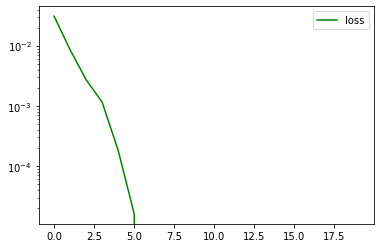

In [26]:
# Train network:

histories = []
with generator:
    h = model.fit(generator, epochs= 20)
    
plt.plot(h.history["loss"], 'g')
#plt.plot(h.history["val_loss"], 'r')
plt.legend(["loss"])
plt.yscale('log')
plt.show()

Again test the performance on synthetic data. 

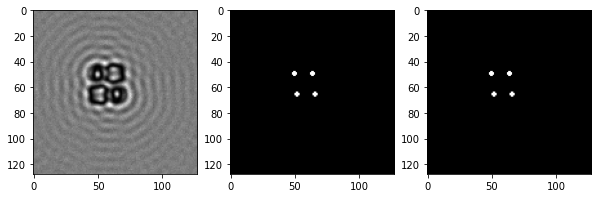

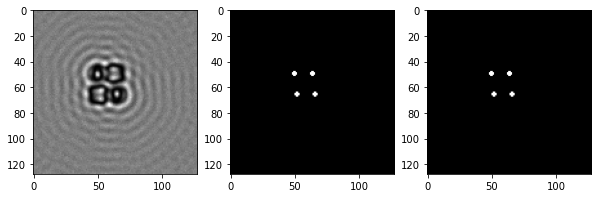

In [27]:
NUMBER_OF_IMAGES = 2


for _ in range(NUMBER_OF_IMAGES):
    plt.figure(figsize=(10, 10))
    dataset.update()
    synthetic = dataset.resolve()
    
    predicted_mask = model.predict(np.array([synthetic]))
    particle_label = get_label(synthetic)
    
    plt.subplot(1, 3, 1)
    plt.imshow(synthetic[..., 0], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.imshow(particle_label[..., 0] * 1.0, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[0, ..., 0] > 0.01, cmap="gray")
    plt.show()

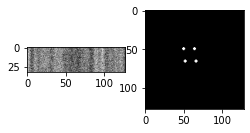

In [28]:
images, real_positions = generator[0]
measured_positions = model.predict(images)
particle_label = get_label(images)

image = np.squeeze(images)
plt.subplot(1, 3, 1)
plt.imshow(image[..., 0], cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(measured_positions[0, ..., 0] > 0.5, cmap="gray")
plt.show()

Now to test on experimental data. Here skimage module is used. 

NB This experimental data is different to the synthetic data so the predictions will not be great. The thresholds will need to played around with to get better results. 

In [30]:
import skimage.io

predictions = model.predict(np.reshape(frame_resize, (1, IMAGE_SIZE, IMAGE_SIZE, 1)))
mask = predictions[:,:,0] >  0.1
cs = np.array(skimage.measure.regionprops(skimage.measure.label(mask)))
cs = np.array([c["Centroid"] for c in cs])

[]


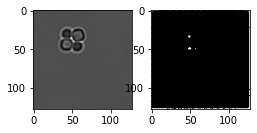

In [41]:
predicted_mask_exp = model.predict(np.array([frame_resize]))
plt.subplot(1, 3, 1)
plt.imshow(frame_resize, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask_exp[0, ..., 0] > 0.00000005, cmap="gray")
plt.show()